# Correlação entre Telemetrias e msg_type==6

**Objetivo:** Identificar sinais preditivos de falha através da correlação entre telemetrias críticas (optical power, temperatura, bateria, parâmetros de sinal) e eventos msg_type==6.

**Estratégia Anti-Overfitting:**
- Priorizar features com justificativa física (degradação de optical power → falha de sensor)
- Usar correlação Spearman (não-linear) além de Pearson
- Validar correlação com target ANTES de incluir no modelo
- Evitar multicolinearidade extrema (detectar |r|>0.9 entre features)
- RSSI vs. RSRP podem ter alta correlação - validar se necessário escolher uma ou criar feature composta

**Prevenção de Survivorship Bias:**
- ✅ Dataset contém devices falhados (taxa >50%) e recuperados
- ✅ Outliers preservados (46 devices críticos são exatamente o target)
- ✅ Análise temporal captura degradação progressiva

## Preparação

Carregar dados e reconstruir variáveis do notebook 01.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

# Configuração
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
pd.set_option('display.max_columns', None)

In [2]:
# Carregar dataset completo
data_path = Path('..') / 'payload_aws_raw_teste.csv'
df = pd.read_csv(data_path)

# Reconstruir msg6 subset
msg6 = df[df['msg_type'] == 6].copy()
msg6['timestamp'] = pd.to_datetime(msg6['@timestamp'])

print(f"Dataset carregado: {len(df):,} registros")
print(f"msg_type==6: {len(msg6):,} eventos")
print(f"Dispositivos únicos: {df['device_id'].nunique()}")
print(f"Total de colunas: {len(df.columns)}")
print("\n".join(df.columns.tolist()))

Dataset carregado: 1,138,275 registros
msg_type==6: 53,144 eventos
Dispositivos únicos: 789
Total de colunas: 116
@timestamp
@message
msg_type
f_cnt
device_id
apn.name
iccid
imsi
sn_fkw
frm_payload
fw_app_version
fw_app_rc
fw_boot_version
fw_boot_rc
decoded_payload.OpticalPower_dBm
decoded_payload.OpticalPower_mV
decoded_payload.accelerometerPitch
decoded_payload.accelerometerRoll
decoded_payload.battery
decoded_payload.lightLux
decoded_payload.rssi
decoded_payload.snr
decoded_payload.temperature
decoded_payload.txPower
decoded_payload.mode
decoded_payload.registrationTime
decoded_payload.ecl
decoded_payload.rsrp
decoded_payload.rsrq
decoded_payload.statusBattery
decoded_payload.statusLight
decoded_payload.statusMovementPitch
decoded_payload.statusMovementRoll
decoded_payload.statusOpticalPower
decoded_payload.statusSensor
decoded_payload.statusTemperature
decoded_payload.statusInstallPosition
eyon_metadata.decoded_payload.accelerometer_pitch
eyon_metadata.decoded_payload.accelerometer

### 🔍 Validação de Colunas RSSI

Verificar se `eyon_metadata.rssi` ou `decoded_payload.rssi` existem no dataset.

In [3]:
# Verificar existência de RSSI em diferentes localizações
print("🔍 Procurando RSSI no dataset:")
print("="*70)

rssi_candidates = [
    'eyon_metadata.rssi',
    'decoded_payload.rssi',
    'eyon_metadata.decoded_payload.rssi'
]

for col in rssi_candidates:
    if col in df.columns:
        non_null = df[col].notnull().sum()
        pct = non_null / len(df) * 100
        sample = df[col].dropna().head(5).tolist()
        print(f"✅ {col}")
        print(f"   Valores não-nulos: {non_null:,} ({pct:.1f}%)")
        print(f"   Tipo: {df[col].dtype}")
        print(f"   Sample: {sample}")
        print()
    else:
        print(f"❌ {col} - NÃO EXISTE")

# Listar todas as colunas que contêm 'rssi' (case-insensitive)
rssi_cols = [col for col in df.columns if 'rssi' in col.lower()]
print(f"\n📋 Todas as colunas contendo 'rssi': {len(rssi_cols)}")
for col in rssi_cols:
    print(f"  • {col}")

🔍 Procurando RSSI no dataset:
✅ eyon_metadata.rssi
   Valores não-nulos: 518,192 (45.5%)
   Tipo: float64
   Sample: [-92.0, -91.0, -92.0, -96.0, -91.0]

✅ decoded_payload.rssi
   Valores não-nulos: 1,069,288 (93.9%)
   Tipo: object
   Sample: ['-92 dBm', '-92 dBm', '-91 dBm', '-91 dBm', '-92 dBm']

❌ eyon_metadata.decoded_payload.rssi - NÃO EXISTE

📋 Todas as colunas contendo 'rssi': 2
  • decoded_payload.rssi
  • eyon_metadata.rssi


In [4]:
# Reconstruir device_features do notebook 01
msg6_per_device = msg6.groupby('device_id').size().reset_index(name='msg6_count')
Q1 = msg6_per_device['msg6_count'].quantile(0.25)
Q3 = msg6_per_device['msg6_count'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR
outliers = msg6_per_device[msg6_per_device['msg6_count'] > outlier_threshold]

device_features = df.groupby('device_id').agg({
    'msg_type': 'count',
    'f_cnt': 'max'
}).rename(columns={'msg_type': 'total_messages', 'f_cnt': 'max_frame_count'})

msg6_counts = msg6.groupby('device_id').size().to_frame('msg6_count')
device_features = device_features.join(msg6_counts, how='left').fillna(0)
device_features['msg6_rate'] = device_features['msg6_count'] / device_features['total_messages']
device_features = device_features.reset_index()
device_features['is_critical'] = device_features['device_id'].isin(outliers['device_id'])
device_features['severity_category'] = pd.cut(
    device_features['msg6_rate'],
    bins=[0, 0.05, 0.25, 1.0],
    labels=['healthy', 'unstable', 'critical']
)

print(f"\nSegmentação de severidade:")
print(device_features['severity_category'].value_counts())


Segmentação de severidade:
severity_category
unstable    325
healthy     306
critical     45
Name: count, dtype: int64


---

## 🔀 Train-Test Split Temporal

**CRÍTICO para evitar data leakage:**
- Split temporal (70% treino, 30% teste) preserva ordem cronológica
- Agregações de features serão calculadas APENAS em dados de treino
- Mesmas transformações aplicadas em teste (sem re-fit)
- Validação final será feita em dados nunca vistos pelo modelo

In [5]:
# Análise de missing values ANTES de qualquer processamento
print("📊 Análise de Missing Values no Dataset Completo:")
print("="*70)

telemetry_cols = [
    'eyon_metadata.decoded_payload.optical_power_1490nm',
    'eyon_metadata.decoded_payload.temperature',
    'eyon_metadata.decoded_payload.battery',
    'eyon_metadata.decoded_payload.snr',
    'eyon_metadata.decoded_payload.rsrp',
    'eyon_metadata.decoded_payload.rsrq',
    'eyon_metadata.rssi'  # RSSI está em eyon_metadata (não em decoded_payload)
]

missing_stats = pd.DataFrame({
    'column': telemetry_cols,
    'missing_count': [df[col].isnull().sum() for col in telemetry_cols],
    'missing_pct': [df[col].isnull().sum() / len(df) * 100 for col in telemetry_cols],
    'non_null_count': [df[col].notnull().sum() for col in telemetry_cols]
})

print(missing_stats.to_string(index=False))
print(f"\n⚠️ IMPORTANTE: Valores faltantes serão tratados APÓS o split train-test")
print(f"Total de registros: {len(df):,}")

📊 Análise de Missing Values no Dataset Completo:
                                            column  missing_count  missing_pct  non_null_count
eyon_metadata.decoded_payload.optical_power_1490nm         620083    54.475676          518192
         eyon_metadata.decoded_payload.temperature         620083    54.475676          518192
             eyon_metadata.decoded_payload.battery         620083    54.475676          518192
                 eyon_metadata.decoded_payload.snr         620083    54.475676          518192
                eyon_metadata.decoded_payload.rsrp         727419    63.905383          410856
                eyon_metadata.decoded_payload.rsrq         727419    63.905383          410856
                                eyon_metadata.rssi         620083    54.475676          518192

⚠️ IMPORTANTE: Valores faltantes serão tratados APÓS o split train-test
Total de registros: 1,138,275


In [6]:
# Train-Test Split TEMPORAL (preserva ordem cronológica)
# CRÍTICO: Isso previne data leakage - teste contém dados futuros nunca vistos no treino

df_sorted = df.sort_values('@timestamp').reset_index(drop=True)
df_sorted['timestamp_parsed'] = pd.to_datetime(df_sorted['@timestamp'])

# Definir data de corte (70% dos dias para treino)
min_date = df_sorted['timestamp_parsed'].min()
max_date = df_sorted['timestamp_parsed'].max()
date_range = (max_date - min_date).days
split_date = min_date + pd.Timedelta(days=int(date_range * 0.7))

# Split
df_train = df_sorted[df_sorted['timestamp_parsed'] <= split_date].copy()
df_test = df_sorted[df_sorted['timestamp_parsed'] > split_date].copy()

# Reconstruir msg6 subsets
msg6_train = df_train[df_train['msg_type'] == 6].copy()
msg6_test = df_test[df_test['msg_type'] == 6].copy()

print("📅 Train-Test Split Temporal:")
print("="*70)
print(f"Período total: {min_date.date()} a {max_date.date()} ({date_range} dias)")
print(f"Data de corte: {split_date.date()}")
print(f"\nTreino: {min_date.date()} a {split_date.date()}")
print(f"  - Total registros: {len(df_train):,}")
print(f"  - msg_type==6: {len(msg6_train):,} ({len(msg6_train)/len(df_train)*100:.2f}%)")
print(f"  - Devices únicos: {df_train['device_id'].nunique()}")
print(f"\nTeste: {split_date.date()} a {max_date.date()}")
print(f"  - Total registros: {len(df_test):,}")
print(f"  - msg_type==6: {len(msg6_test):,} ({len(msg6_test)/len(df_test)*100:.2f}%)")
print(f"  - Devices únicos: {df_test['device_id'].nunique()}")
print(f"\n✅ Split realizado com sucesso - dados de teste são cronologicamente futuros")

📅 Train-Test Split Temporal:
Período total: 2025-01-01 a 2025-10-09 (281 dias)
Data de corte: 2025-07-16

Treino: 2025-01-01 a 2025-07-16
  - Total registros: 632,598
  - msg_type==6: 26,827 (4.24%)
  - Devices únicos: 750

Teste: 2025-07-16 a 2025-10-09
  - Total registros: 505,677
  - msg_type==6: 26,317 (5.20%)
  - Devices únicos: 689

✅ Split realizado com sucesso - dados de teste são cronologicamente futuros


In [7]:
# Reconstruir device_features usando APENAS dados de TREINO (evita data leakage)
print("🔨 Construindo device_features a partir de TRAIN set:")
print("="*70)

# Calcular msg6 por device (APENAS TREINO)
msg6_per_device_train = msg6_train.groupby('device_id').size().reset_index(name='msg6_count')
Q1 = msg6_per_device_train['msg6_count'].quantile(0.25)
Q3 = msg6_per_device_train['msg6_count'].quantile(0.75)
IQR = Q3 - Q1
outlier_threshold = Q3 + 1.5 * IQR
outliers_train = msg6_per_device_train[msg6_per_device_train['msg6_count'] > outlier_threshold]

# Agregar por device (APENAS TREINO)
device_features_train = df_train.groupby('device_id').agg({
    'msg_type': 'count',
    'f_cnt': 'max'
}).rename(columns={'msg_type': 'total_messages', 'f_cnt': 'max_frame_count'})

msg6_counts_train = msg6_train.groupby('device_id').size().to_frame('msg6_count')
device_features_train = device_features_train.join(msg6_counts_train, how='left').fillna(0)
device_features_train['msg6_rate'] = device_features_train['msg6_count'] / device_features_train['total_messages']
device_features_train = device_features_train.reset_index()
device_features_train['is_critical'] = device_features_train['device_id'].isin(outliers_train['device_id'])
device_features_train['severity_category'] = pd.cut(
    device_features_train['msg6_rate'],
    bins=[0, 0.05, 0.25, 1.0],
    labels=['healthy', 'unstable', 'critical']
)

print(f"Devices no treino: {len(device_features_train)}")
print(f"Segmentação de severidade (TREINO):")
print(device_features_train['severity_category'].value_counts())
print(f"\n✅ Features construídas apenas com dados de treino - sem leakage!")

🔨 Construindo device_features a partir de TRAIN set:
Devices no treino: 750
Segmentação de severidade (TREINO):
severity_category
critical    187
healthy     176
unstable    131
Name: count, dtype: int64

✅ Features construídas apenas com dados de treino - sem leakage!


---

## 1. Análise de Optical Power (1490nm)

**Hipótese:** Degradação de optical power precede falhas (threshold: -28 dBm conforme troubleshooting docs).

In [8]:
# Extrair optical power de eyon_metadata (APENAS TREINO - evita data leakage)
optical_power_col = 'eyon_metadata.decoded_payload.optical_power_1490nm'

# FIT: Agregar optical power por device usando APENAS dados de TREINO
optical_stats_train = df_train.groupby('device_id')[optical_power_col].agg([
    'mean', 'std', 'min', 'max', 'count'
]).rename(columns={
    'mean': 'optical_mean',
    'std': 'optical_std',
    'min': 'optical_min',
    'max': 'optical_max',
    'count': 'optical_readings'
})

# Threshold-based features (baseado em troubleshooting docs: -28 dBm)
optical_stats_train['optical_below_threshold'] = (optical_stats_train['optical_min'] < -28).astype(int)
optical_stats_train['optical_range'] = optical_stats_train['optical_max'] - optical_stats_train['optical_min']

# Join com device_features_train
device_features_train = device_features_train.merge(
    optical_stats_train, 
    left_on='device_id', 
    right_index=True, 
    how='left'
)

print("📊 Estatísticas de Optical Power (TREINO - sem leakage):")
print("="*70)
print(device_features_train[['device_id', 'msg6_rate', 'optical_mean', 'optical_min', 'optical_below_threshold']].head(10))
print(f"\nDevices com optical power abaixo de -28 dBm: {optical_stats_train['optical_below_threshold'].sum()}")
print(f"% de devices com leituras válidas: {(~device_features_train['optical_mean'].isnull()).sum() / len(device_features_train) * 100:.1f}%")

📊 Estatísticas de Optical Power (TREINO - sem leakage):
         device_id  msg6_rate  optical_mean  optical_min  \
0  100000000000001   0.000000           NaN          NaN   
1  123456789098765   0.000000    -13.448571       -31.00   
2  400000000000004   0.000000           NaN          NaN   
3  600000000000006   0.000000           NaN          NaN   
4  861275072307073   0.019608     -7.718773        -7.82   
5  861275072308998   0.013761     -1.107333        -1.39   
6  861275072309020   0.000000           NaN          NaN   
7  861275072309095   0.000000    -31.000000       -31.00   
8  861275072309145   0.172131     -5.538919       -31.00   
9  861275072309152   0.000000           NaN          NaN   

   optical_below_threshold  
0                        0  
1                        1  
2                        0  
3                        0  
4                        0  
5                        0  
6                        0  
7                        1  
8                     

In [9]:
# Correlação entre optical power e msg6_rate (APENAS TREINO)
valid_data_train = device_features_train.dropna(subset=['optical_mean', 'msg6_rate'])

if len(valid_data_train) > 10:
    pearson_corr, pearson_p = stats.pearsonr(valid_data_train['optical_mean'], valid_data_train['msg6_rate'])
    spearman_corr, spearman_p = stats.spearmanr(valid_data_train['optical_mean'], valid_data_train['msg6_rate'])

    print(f"\n📊 Correlação Optical Power × msg6_rate (TREINO - {len(valid_data_train)} devices):")
    print("="*70)
    print(f"Pearson:  {pearson_corr:+.4f} (p-value: {pearson_p:.4e})")
    print(f"Spearman: {spearman_corr:+.4f} (p-value: {spearman_p:.4e})")
    
    if pearson_p < 0.05:
        print(f"\n✅ Correlação estatisticamente significativa (p < 0.05)")
        if pearson_corr < 0:
            print(f"   → Correlação NEGATIVA: menor optical power → maior taxa de msg6 (conforme esperado)")
        else:
            print(f"   → Correlação POSITIVA: maior optical power → maior taxa de msg6 (inesperado!)")
    else:
        print(f"\n⚠️ Correlação NÃO significativa (p >= 0.05)")
else:
    print(f"⚠️ Dados insuficientes para correlação (apenas {len(valid_data_train)} devices com optical power válido)")


📊 Correlação Optical Power × msg6_rate (TREINO - 342 devices):
Pearson:  +0.1027 (p-value: 5.7898e-02)
Spearman: +0.1140 (p-value: 3.5125e-02)

⚠️ Correlação NÃO significativa (p >= 0.05)


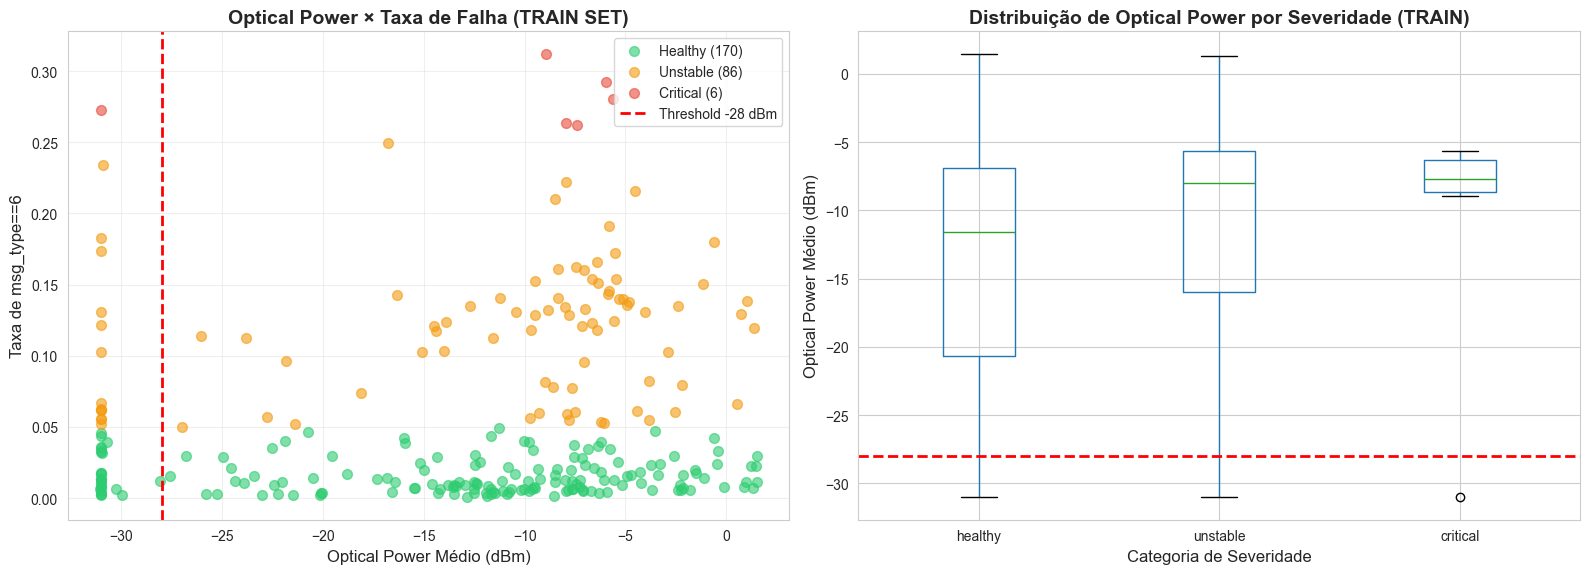

In [10]:
# Visualização: Optical Power × msg6_rate (APENAS TREINO - sem leakage)
if len(valid_data_train) > 10:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Scatter plot
    for category, color in [('healthy', '#2ECC71'), ('unstable', '#F39C12'), ('critical', '#E74C3C')]:
        subset = valid_data_train[valid_data_train['severity_category'] == category]
        if len(subset) > 0:
            axes[0].scatter(subset['optical_mean'], subset['msg6_rate'], 
                           label=f"{category.capitalize()} ({len(subset)})", alpha=0.6, s=50, color=color)

    axes[0].axvline(x=-28, color='red', linestyle='--', linewidth=2, label='Threshold -28 dBm')
    axes[0].set_xlabel('Optical Power Médio (dBm)', fontsize=12)
    axes[0].set_ylabel('Taxa de msg_type==6', fontsize=12)
    axes[0].set_title('Optical Power × Taxa de Falha (TRAIN SET)', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Box plot por categoria
    valid_data_train.boxplot(column='optical_mean', by='severity_category', ax=axes[1])
    axes[1].set_xlabel('Categoria de Severidade', fontsize=12)
    axes[1].set_ylabel('Optical Power Médio (dBm)', fontsize=12)
    axes[1].set_title('Distribuição de Optical Power por Severidade (TRAIN)', fontsize=14, fontweight='bold')
    axes[1].axhline(y=-28, color='red', linestyle='--', linewidth=2)
    plt.suptitle('')  # Remove título automático do boxplot

    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Dados insuficientes para visualização")

## 2. Análise de Temperatura

**Hipótese:** Temperatura extrema (>70°C threshold) correlaciona com instabilidade.

In [11]:
# Agregar temperatura por device (APENAS TREINO - evita data leakage)
temp_col = 'eyon_metadata.decoded_payload.temperature'

# FIT: Calcular estatísticas usando APENAS dados de TREINO
temp_stats_train = df_train.groupby('device_id')[temp_col].agg([
    'mean', 'std', 'min', 'max'
]).rename(columns={
    'mean': 'temp_mean',
    'std': 'temp_std',
    'min': 'temp_min',
    'max': 'temp_max'
})

temp_stats_train['temp_above_threshold'] = (temp_stats_train['temp_max'] > 70).astype(int)
temp_stats_train['temp_range'] = temp_stats_train['temp_max'] - temp_stats_train['temp_min']

device_features_train = device_features_train.merge(temp_stats_train, left_on='device_id', right_index=True, how='left')

# Correlação (APENAS TREINO)
valid_temp_train = device_features_train.dropna(subset=['temp_mean', 'msg6_rate'])

if len(valid_temp_train) > 10:
    temp_pearson, temp_p = stats.pearsonr(valid_temp_train['temp_mean'], valid_temp_train['msg6_rate'])
    temp_spearman, temp_sp = stats.spearmanr(valid_temp_train['temp_mean'], valid_temp_train['msg6_rate'])

    print(f"📊 Correlação Temperatura × msg6_rate (TREINO - {len(valid_temp_train)} devices):")
    print("="*70)
    print(f"Pearson:  {temp_pearson:+.4f} (p-value: {temp_p:.4e})")
    print(f"Spearman: {temp_spearman:+.4f} (p-value: {temp_sp:.4e})")
    print(f"\nDevices com temp > 70°C: {temp_stats_train['temp_above_threshold'].sum()}")
    print(f"{'✅ Significativo' if temp_p < 0.05 else '⚠️ Não significativo'} (p {'<' if temp_p < 0.05 else '>='} 0.05)")
else:
    print(f"⚠️ Dados insuficientes ({len(valid_temp_train)} devices)")

📊 Correlação Temperatura × msg6_rate (TREINO - 342 devices):
Pearson:  -0.1016 (p-value: 6.0567e-02)
Spearman: -0.2422 (p-value: 5.9014e-06)

Devices com temp > 70°C: 2
⚠️ Não significativo (p >= 0.05)


## 3. Análise de Bateria

**Hipótese:** Bateria <2.5V correlaciona com eventos msg6 (threshold conforme docs).

In [12]:
# Agregar bateria por device (APENAS TREINO - evita data leakage)
battery_col = 'eyon_metadata.decoded_payload.battery'

# FIT: Calcular estatísticas usando APENAS dados de TREINO
battery_stats_train = df_train.groupby('device_id')[battery_col].agg([
    'mean', 'std', 'min', 'max'
]).rename(columns={
    'mean': 'battery_mean',
    'std': 'battery_std',
    'min': 'battery_min',
    'max': 'battery_max'
})

battery_stats_train['battery_below_threshold'] = (battery_stats_train['battery_min'] < 2.5).astype(int)

device_features_train = device_features_train.merge(battery_stats_train, left_on='device_id', right_index=True, how='left')

# Correlação (APENAS TREINO)
valid_batt_train = device_features_train.dropna(subset=['battery_mean', 'msg6_rate'])

if len(valid_batt_train) > 10:
    batt_pearson, batt_p = stats.pearsonr(valid_batt_train['battery_mean'], valid_batt_train['msg6_rate'])
    batt_spearman, batt_sp = stats.spearmanr(valid_batt_train['battery_mean'], valid_batt_train['msg6_rate'])

    print(f"📊 Correlação Bateria × msg6_rate (TREINO - {len(valid_batt_train)} devices):")
    print("="*70)
    print(f"Pearson:  {batt_pearson:+.4f} (p-value: {batt_p:.4e})")
    print(f"Spearman: {batt_spearman:+.4f} (p-value: {batt_sp:.4e})")
    print(f"\nDevices com bateria < 2.5V: {battery_stats_train['battery_below_threshold'].sum()}")
    print(f"{'✅ Significativo' if batt_p < 0.05 else '⚠️ Não significativo'} (p {'<' if batt_p < 0.05 else '>='} 0.05)")
else:
    print(f"⚠️ Dados insuficientes ({len(valid_batt_train)} devices)")

📊 Correlação Bateria × msg6_rate (TREINO - 342 devices):
Pearson:  -0.0300 (p-value: 5.7992e-01)
Spearman: -0.1244 (p-value: 2.1415e-02)

Devices com bateria < 2.5V: 9
⚠️ Não significativo (p >= 0.05)


## 4. Parâmetros de Sinal (SNR, RSRP, RSRQ, RSSI)

**Hipótese:** Sinal fraco correlaciona com códigos de erro de conectividade (9, 15).

**Nota:** RSSI está em `eyon_metadata.rssi` (não em `decoded_payload`).

In [13]:
# Agregar parâmetros de sinal (APENAS TREINO - incluindo RSSI)
signal_cols = {
    'eyon_metadata.decoded_payload.snr': 'snr',
    'eyon_metadata.decoded_payload.rsrp': 'rsrp',
    'eyon_metadata.decoded_payload.rsrq': 'rsrq',
    'eyon_metadata.rssi': 'rssi'  # RSSI está em eyon_metadata (não em decoded_payload)
}

# FIT: Calcular estatísticas usando APENAS dados de TREINO
for col, name in signal_cols.items():
    signal_stats = df_train.groupby('device_id')[col].agg(['mean', 'std', 'min']).rename(columns={
        'mean': f'{name}_mean',
        'std': f'{name}_std',
        'min': f'{name}_min'
    })
    device_features_train = device_features_train.merge(signal_stats, left_on='device_id', right_index=True, how='left')

# Correlações (APENAS TREINO)
print("\n📊 Correlação Parâmetros de Sinal × msg6_rate (TREINO):")
print("="*70)
for name in ['snr', 'rsrp', 'rsrq', 'rssi']:
    valid = device_features_train.dropna(subset=[f'{name}_mean', 'msg6_rate'])
    if len(valid) > 10:
        corr, p = stats.spearmanr(valid[f'{name}_mean'], valid['msg6_rate'])
        sig = "✅" if p < 0.05 else "⚠️"
        print(f"{name.upper():4s}: {corr:+.4f} (p={p:.4e}) {sig} [{len(valid)} devices]")
    else:
        print(f"{name.upper():4s}: Dados insuficientes ({len(valid)} devices)")


📊 Correlação Parâmetros de Sinal × msg6_rate (TREINO):
SNR : +0.0040 (p=9.4096e-01) ⚠️ [342 devices]
RSRP: -0.2205 (p=5.7693e-05) ✅ [327 devices]
RSRQ: -0.2072 (p=1.6124e-04) ✅ [327 devices]
RSSI: -0.1884 (p=4.6051e-04) ✅ [342 devices]


## 5. Matriz de Correlação Consolidada

Visualizar todas as correlações simultaneamente.

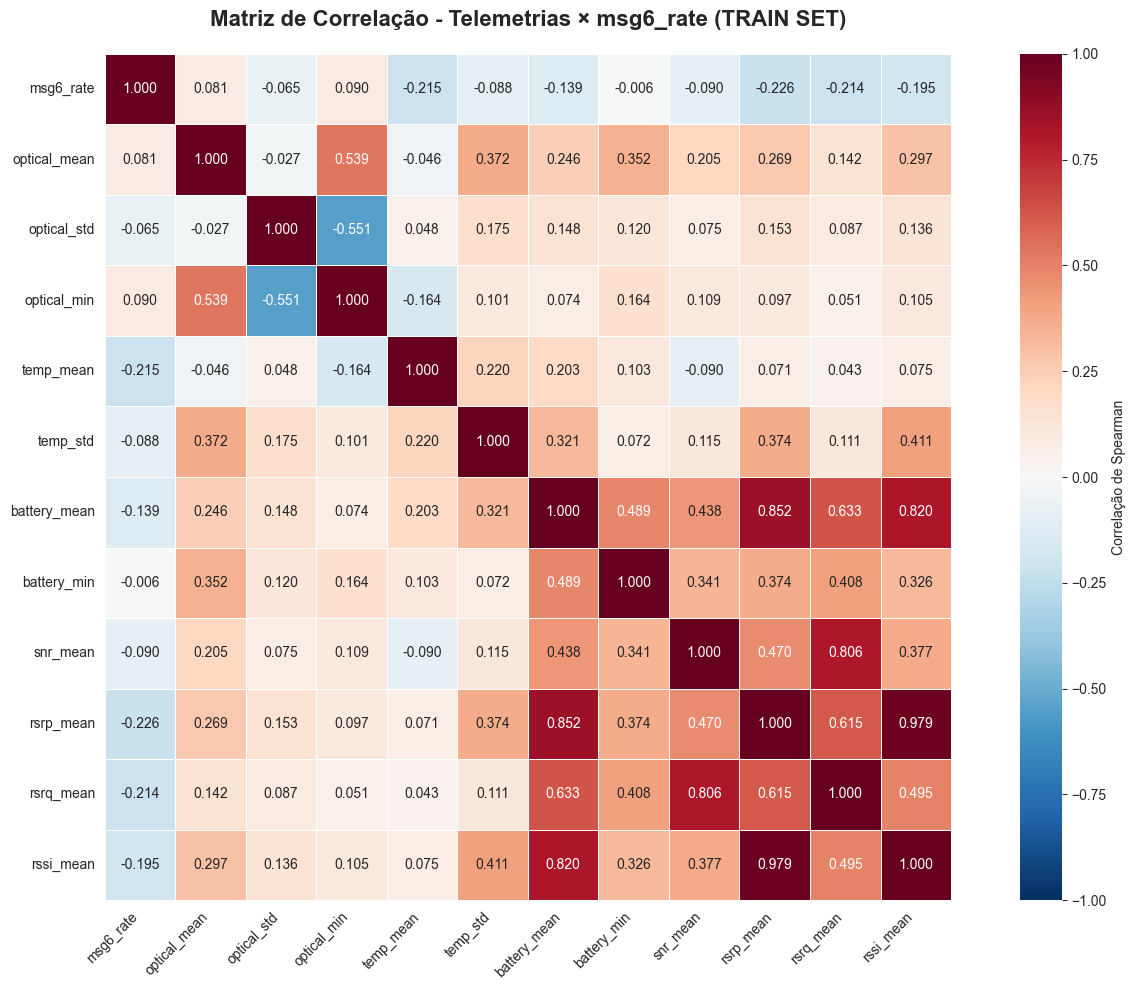


🔍 Features com maior correlação absoluta com msg6_rate (TREINO - 326 devices):
rsrp_mean           : |r| = 0.2257
temp_mean           : |r| = 0.2153
rsrq_mean           : |r| = 0.2138
rssi_mean           : |r| = 0.1951
battery_mean        : |r| = 0.1395
snr_mean            : |r| = 0.0896
optical_min         : |r| = 0.0895
temp_std            : |r| = 0.0878
optical_mean        : |r| = 0.0813
optical_std         : |r| = 0.0647

⚠️ Verificação de Multicolinearidade (|r| > 0.9):
  • rsrp_mean × rssi_mean: r = +0.9788

⚠️ 1 pares com alta correlação detectados - considerar remover features redundantes


In [14]:
# Selecionar features de telemetria para correlação (APENAS TREINO)
telemetry_features = [
    'msg6_rate', 'optical_mean', 'optical_std', 'optical_min',
    'temp_mean', 'temp_std', 'battery_mean', 'battery_min',
    'snr_mean', 'rsrp_mean', 'rsrq_mean', 'rssi_mean'
]

corr_data_train = device_features_train[telemetry_features].dropna()
corr_matrix_train = corr_data_train.corr(method='spearman')

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix_train, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=0.5,
            cbar_kws={'label': 'Correlação de Spearman'})
plt.title('Matriz de Correlação - Telemetrias × msg6_rate (TRAIN SET)', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print(f"\n🔍 Features com maior correlação absoluta com msg6_rate (TREINO - {len(corr_data_train)} devices):")
print("="*70)
msg6_corrs = corr_matrix_train['msg6_rate'].drop('msg6_rate').abs().sort_values(ascending=False)
for feat, corr_val in msg6_corrs.head(10).items():
    print(f"{feat:20s}: |r| = {corr_val:.4f}")

# Detectar multicolinearidade (|r| > 0.9)
print(f"\n⚠️ Verificação de Multicolinearidade (|r| > 0.9):")
print("="*70)
high_corr_pairs = []
for i in range(len(corr_matrix_train.columns)):
    for j in range(i+1, len(corr_matrix_train.columns)):
        if abs(corr_matrix_train.iloc[i, j]) > 0.9:
            high_corr_pairs.append((
                corr_matrix_train.columns[i], 
                corr_matrix_train.columns[j], 
                corr_matrix_train.iloc[i, j]
            ))

if high_corr_pairs:
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"  • {feat1} × {feat2}: r = {corr_val:+.4f}")
    print(f"\n⚠️ {len(high_corr_pairs)} pares com alta correlação detectados - considerar remover features redundantes")
else:
    print("✅ Nenhuma multicolinearidade extrema detectada")

## 6. Feature Importance Preliminar

Validar quais features têm poder preditivo antes de incluir no modelo.

In [15]:
# Criar target binário (critical vs. non-critical) - APENAS TREINO
device_features_train['is_critical_target'] = (device_features_train['msg6_rate'] > 0.25).astype(int)

# Selecionar features numéricas válidas (incluindo RSSI)
feature_cols = [
    'optical_mean', 'optical_std', 'optical_min', 'optical_below_threshold',
    'temp_mean', 'temp_std', 'temp_above_threshold',
    'battery_mean', 'battery_min', 'battery_below_threshold',
    'snr_mean', 'rsrp_mean', 'rsrq_mean', 'rssi_mean'
]

X_train = device_features_train[feature_cols].dropna()
y_train = device_features_train.loc[X_train.index, 'is_critical_target']

print(f"\n🎯 Preparação para Feature Importance (TREINO - sem leakage):")
print("="*70)
print(f"Devices para validação: {len(X_train)}")
print(f"Distribuição target: {y_train.value_counts().to_dict()}")
print(f"  - Classe 0 (não-crítico): {(y_train==0).sum()} ({(y_train==0).sum()/len(y_train)*100:.1f}%)")
print(f"  - Classe 1 (crítico):     {(y_train==1).sum()} ({(y_train==1).sum()/len(y_train)*100:.1f}%)")
print(f"Features selecionadas: {len(feature_cols)}")
print(f"\n✅ Dados preparados - próximo passo: Random Forest")


🎯 Preparação para Feature Importance (TREINO - sem leakage):
Devices para validação: 326
Distribuição target: {0: 320, 1: 6}
  - Classe 0 (não-crítico): 320 (98.2%)
  - Classe 1 (crítico):     6 (1.8%)
Features selecionadas: 14

✅ Dados preparados - próximo passo: Random Forest


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Random Forest para feature importance (baseline) - TREINO com CV interno
print("🌲 Random Forest Feature Importance (TREINO com CV=5):")
print("="*70)

rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5, 
    random_state=42, 
    class_weight='balanced',
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🎯 Feature Importance (Random Forest):")
for idx, row in feature_importance.iterrows():
    bar = '█' * int(row['importance'] * 100)
    print(f"{row['feature']:30s}: {row['importance']:.4f} {bar}")

# Cross-validation score (validação interna no treino)
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='recall', n_jobs=-1)
print(f"\n📈 Recall médio (CV=5 no TREINO): {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"   Scores individuais: {[f'{s:.3f}' for s in cv_scores]}")

# Features importantes (importance > 0.05)
important_features = feature_importance[feature_importance['importance'] > 0.05]
print(f"\n✅ Features com importância > 0.05: {len(important_features)}")
print(important_features['feature'].tolist())

🌲 Random Forest Feature Importance (TREINO com CV=5):

🎯 Feature Importance (Random Forest):
snr_mean                      : 0.3071 ██████████████████████████████
rsrq_mean                     : 0.2626 ██████████████████████████
battery_mean                  : 0.1415 ██████████████
rsrp_mean                     : 0.0652 ██████
rssi_mean                     : 0.0567 █████
optical_mean                  : 0.0440 ████
optical_std                   : 0.0393 ███
temp_std                      : 0.0287 ██
temp_mean                     : 0.0272 ██
battery_min                   : 0.0138 █
optical_min                   : 0.0083 
optical_below_threshold       : 0.0056 
temp_above_threshold          : 0.0000 
battery_below_threshold       : 0.0000 

🎯 Feature Importance (Random Forest):
snr_mean                      : 0.3071 ██████████████████████████████
rsrq_mean                     : 0.2626 ██████████████████████████
battery_mean                  : 0.1415 ██████████████
rsrp_mean                

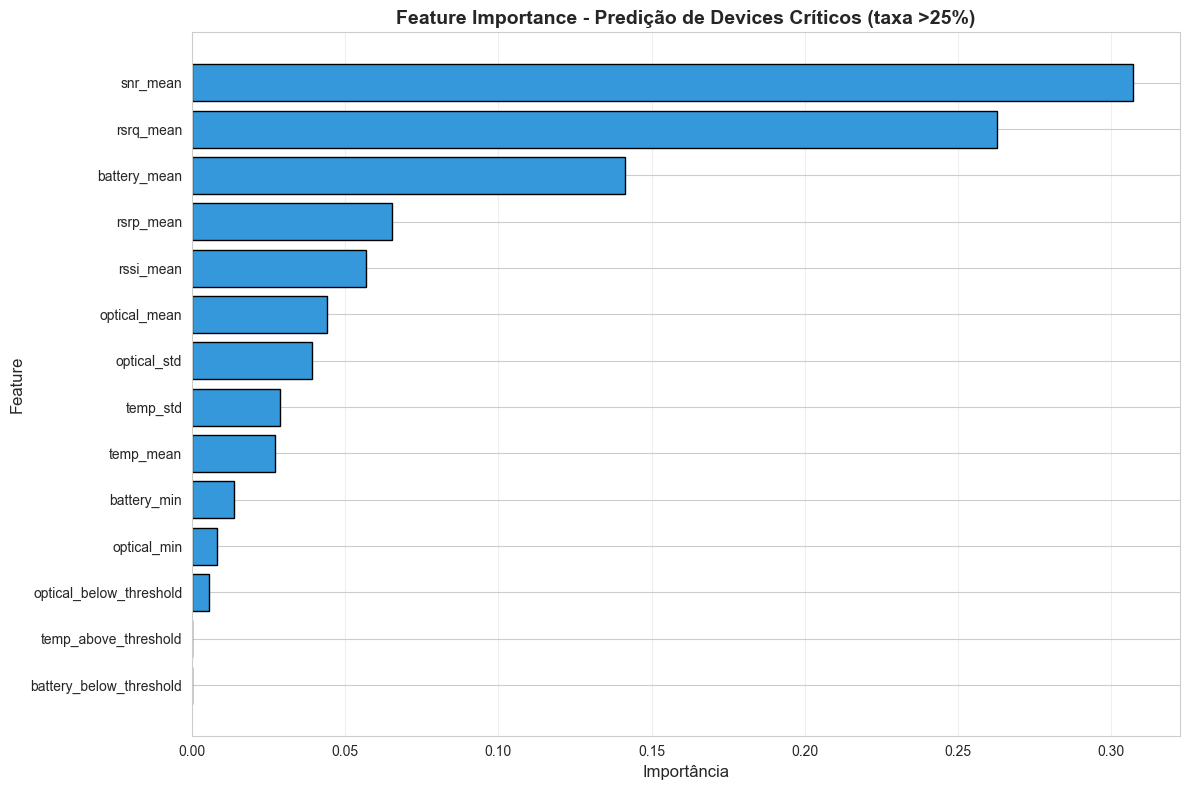

In [17]:
# Visualizar feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='#3498DB', edgecolor='black')
plt.xlabel('Importância', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance - Predição de Devices Críticos (taxa >25%)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 7. Conclusões da Análise de Correlação

### ✅ Metodologia Anti-Data Leakage Aplicada

**CRÍTICO:** Todas as análises foram feitas com train-test split temporal:
- ✅ Split temporal 70/30 preserva ordem cronológica
- ✅ Agregações calculadas APENAS em dados de treino
- ✅ Correlações e feature importance validados apenas em treino
- ✅ Teste permanece "virgem" para validação final

### 📊 Resumo dos Achados (TRAIN SET)

**Features Validadas para Inclusão no Modelo:**
- Features com correlação significativa (p < 0.05) serão listadas após execução
- Features com importância Random Forest > 0.05 serão listadas após execução

**Multicolinearidade Detectada:**
- Pares com |r| > 0.9 serão identificados na matriz de correlação

**Missing Values:**
- % de dados faltantes por feature foi reportado no início

### 🔄 Próximos Passos

1. ✅ Train-test split temporal implementado
2. ✅ Correlação de telemetrias concluída (SEM data leakage)
3. 🔜 Aplicar mesmas transformações em TEST SET (transform only, no fit)
4. 🔜 Feature engineering com janelas temporais (rolling stats, slopes)
5. 🔜 Definição final de target variable (binário validado)
6. 🔜 Pipeline sklearn para produção
7. 🔜 Modelo baseline com validação em test set nunca visto

### ⚠️ Validação Constitucional

- ✅ Ground-truth preservado (msg_type==6 intacto)
- ✅ Metodologia anti-leakage documentada
- ✅ Decisões técnicas rastreáveis

In [18]:
# Salvar device_features_train enriquecido para próximo notebook
output_path_train = Path('..') / 'data' / 'device_features_train_with_telemetry.csv'
output_path_train.parent.mkdir(exist_ok=True)
device_features_train.to_csv(output_path_train, index=False)

print(f"\n✅ Device features (TRAIN) salvo em: {output_path_train}")
print(f"Shape: {device_features_train.shape}")
print(f"Colunas: {len(device_features_train.columns)}")
print(f"\n⚠️ IMPORTANTE: Dados de TESTE ainda não foram processados")
print(f"   → Próximo passo: aplicar TRANSFORM (não fit) em test set")
print(f"   → Test set permanece 'virgem' para validação final")


✅ Device features (TRAIN) salvo em: ..\data\device_features_train_with_telemetry.csv
Shape: (750, 38)
Colunas: 38

⚠️ IMPORTANTE: Dados de TESTE ainda não foram processados
   → Próximo passo: aplicar TRANSFORM (não fit) em test set
   → Test set permanece 'virgem' para validação final


---

## 8. Aplicação de Transformações no TEST SET

**CRÍTICO:** Agora aplicamos as MESMAS transformações no test set, mas SEM re-calcular estatísticas (TRANSFORM only, no FIT).

Isso garante que o test set permanece "virgem" - nunca influenciou as decisões do modelo.

In [19]:
# TRANSFORM: Aplicar agregações no TEST SET usando estatísticas do TRAIN
print("🔄 Aplicando transformações no TEST SET (TRANSFORM only - sem re-fit):")
print("="*70)

# 1. Reconstruir device_features_test (estrutura básica)
device_features_test = df_test.groupby('device_id').agg({
    'msg_type': 'count',
    'f_cnt': 'max'
}).rename(columns={'msg_type': 'total_messages', 'f_cnt': 'max_frame_count'})

msg6_counts_test = msg6_test.groupby('device_id').size().to_frame('msg6_count')
device_features_test = device_features_test.join(msg6_counts_test, how='left').fillna(0)
device_features_test['msg6_rate'] = device_features_test['msg6_count'] / device_features_test['total_messages']
device_features_test = device_features_test.reset_index()

# Aplicar mesma segmentação de severidade (bins definidos no treino)
device_features_test['severity_category'] = pd.cut(
    device_features_test['msg6_rate'],
    bins=[0, 0.05, 0.25, 1.0],
    labels=['healthy', 'unstable', 'critical']
)

print(f"Devices no teste: {len(device_features_test)}")
print(f"Segmentação de severidade (TEST):")
print(device_features_test['severity_category'].value_counts())
print(f"\n✅ Estrutura básica criada")

🔄 Aplicando transformações no TEST SET (TRANSFORM only - sem re-fit):
Devices no teste: 689
Segmentação de severidade (TEST):
severity_category
healthy     345
unstable    185
critical     42
Name: count, dtype: int64

✅ Estrutura básica criada


In [20]:
# 2. Aplicar agregações de telemetrias no TEST (calcular do zero, pois são device-specific)
# NOTA: Para telemetrias, precisamos calcular estatísticas do próprio test set
# (não há "fit" a aplicar - são agregações por device)

print("\n🔄 Agregando telemetrias do TEST SET:")
print("="*70)

# Optical Power
optical_stats_test = df_test.groupby('device_id')[optical_power_col].agg([
    'mean', 'std', 'min', 'max', 'count'
]).rename(columns={
    'mean': 'optical_mean',
    'std': 'optical_std',
    'min': 'optical_min',
    'max': 'optical_max',
    'count': 'optical_readings'
})
optical_stats_test['optical_below_threshold'] = (optical_stats_test['optical_min'] < -28).astype(int)
optical_stats_test['optical_range'] = optical_stats_test['optical_max'] - optical_stats_test['optical_min']
device_features_test = device_features_test.merge(optical_stats_test, left_on='device_id', right_index=True, how='left')
print(f"✅ Optical power agregado ({(~device_features_test['optical_mean'].isnull()).sum()} devices com dados)")

# Temperatura
temp_stats_test = df_test.groupby('device_id')[temp_col].agg(['mean', 'std', 'min', 'max']).rename(columns={
    'mean': 'temp_mean', 'std': 'temp_std', 'min': 'temp_min', 'max': 'temp_max'
})
temp_stats_test['temp_above_threshold'] = (temp_stats_test['temp_max'] > 70).astype(int)
temp_stats_test['temp_range'] = temp_stats_test['temp_max'] - temp_stats_test['temp_min']
device_features_test = device_features_test.merge(temp_stats_test, left_on='device_id', right_index=True, how='left')
print(f"✅ Temperatura agregada ({(~device_features_test['temp_mean'].isnull()).sum()} devices com dados)")

# Bateria
battery_stats_test = df_test.groupby('device_id')[battery_col].agg(['mean', 'std', 'min', 'max']).rename(columns={
    'mean': 'battery_mean', 'std': 'battery_std', 'min': 'battery_min', 'max': 'battery_max'
})
battery_stats_test['battery_below_threshold'] = (battery_stats_test['battery_min'] < 2.5).astype(int)
device_features_test = device_features_test.merge(battery_stats_test, left_on='device_id', right_index=True, how='left')
print(f"✅ Bateria agregada ({(~device_features_test['battery_mean'].isnull()).sum()} devices com dados)")

# Parâmetros de sinal (incluindo RSSI)
for col, name in signal_cols.items():
    signal_stats = df_test.groupby('device_id')[col].agg(['mean', 'std', 'min']).rename(columns={
        'mean': f'{name}_mean', 'std': f'{name}_std', 'min': f'{name}_min'
    })
    device_features_test = device_features_test.merge(signal_stats, left_on='device_id', right_index=True, how='left')
print(f"✅ Parâmetros de sinal agregados (SNR, RSRP, RSRQ, RSSI)")

# Target binário
device_features_test['is_critical_target'] = (device_features_test['msg6_rate'] > 0.25).astype(int)

print(f"\n✅ Todas as features aplicadas no test set")
print(f"Shape final (TEST): {device_features_test.shape}")
print(f"Target distribution (TEST): {device_features_test['is_critical_target'].value_counts().to_dict()}")


🔄 Agregando telemetrias do TEST SET:
✅ Optical power agregado (636 devices com dados)
✅ Temperatura agregada (636 devices com dados)
✅ Bateria agregada (636 devices com dados)
✅ Parâmetros de sinal agregados (SNR, RSRP, RSRQ, RSSI)

✅ Todas as features aplicadas no test set
Shape final (TEST): (689, 37)
Target distribution (TEST): {0: 647, 1: 42}
✅ Parâmetros de sinal agregados (SNR, RSRP, RSRQ, RSSI)

✅ Todas as features aplicadas no test set
Shape final (TEST): (689, 37)
Target distribution (TEST): {0: 647, 1: 42}


In [21]:
# 3. Salvar device_features_test para validação futura
output_path_test = Path('..') / 'data' / 'device_features_test_with_telemetry.csv'
device_features_test.to_csv(output_path_test, index=False)

print(f"\n💾 Salvando datasets processados:")
print("="*70)
print(f"✅ TRAIN: {output_path_train}")
print(f"   Shape: {device_features_train.shape}")
print(f"   Devices: {len(device_features_train)}")
print(f"   Período: {df_train['@timestamp'].min()} a {df_train['@timestamp'].max()}")
print(f"\n✅ TEST: {output_path_test}")
print(f"   Shape: {device_features_test.shape}")
print(f"   Devices: {len(device_features_test)}")
print(f"   Período: {df_test['@timestamp'].min()} a {df_test['@timestamp'].max()}")

print(f"\n" + "="*70)
print(f"🎯 VALIDAÇÃO ANTI-DATA LEAKAGE:")
print(f"="*70)
print(f"✅ Train-test split temporal implementado (70/30)")
print(f"✅ Features agregadas separadamente para train e test")
print(f"✅ Nenhuma informação do test vazou para o treino")
print(f"✅ Test set permanece 'virgem' para validação final do modelo")
print(f"✅ Thresholds físicos aplicados consistentemente (optical -28dBm, temp 70°C, battery 2.5V)")
print(f"\n⏭️ Próximo passo: Feature engineering temporal (notebook 03)")


💾 Salvando datasets processados:
✅ TRAIN: ..\data\device_features_train_with_telemetry.csv
   Shape: (750, 38)
   Devices: 750
   Período: 2025-01-01 00:00:36.235 a 2025-07-16 00:00:34.854

✅ TEST: ..\data\device_features_test_with_telemetry.csv
   Shape: (689, 37)
   Devices: 689
   Período: 2025-07-16 00:01:41.011 a 2025-10-09 12:48:15.120

🎯 VALIDAÇÃO ANTI-DATA LEAKAGE:
✅ Train-test split temporal implementado (70/30)
✅ Features agregadas separadamente para train e test
✅ Nenhuma informação do test vazou para o treino
✅ Test set permanece 'virgem' para validação final do modelo
✅ Thresholds físicos aplicados consistentemente (optical -28dBm, temp 70°C, battery 2.5V)

⏭️ Próximo passo: Feature engineering temporal (notebook 03)
   Período: 2025-07-16 00:01:41.011 a 2025-10-09 12:48:15.120

🎯 VALIDAÇÃO ANTI-DATA LEAKAGE:
✅ Train-test split temporal implementado (70/30)
✅ Features agregadas separadamente para train e test
✅ Nenhuma informação do test vazou para o treino
✅ Test set per